
# Contours Visualization Algorithm Development


In [2]:
from typing import List
import itertools
import os
import shutil
import uuid
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path
import subprocess
import tempfile
import time
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

# !pip install opencv-python-headless
import cv2

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError, HttpResponseError

## Read Heat-Extremes Dataset

Heat-extreme datasets are produced by our dedicated pipeline which is upstream of this visualization pipeline. This is a visualization tool which extracts metadata from heat extreme events and produces visualizations.

In [3]:
####################################
# Read dataset
####################################

DATASET = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"

# import heat extremes data
ds = xr.open_mfdataset(DATASET)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

YEAR = ds.attrs['Analysis year']

4 days
5 K above


## Define Contour Object

The end goal of the Contours algorithm was to track the progress of daily heat events and extract metadata which can help interpret the visualization we produce. Our approach was to use the computer vision package [OpenCV](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html#intro)’s [findContours](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gae4156f04053c44f886e387cff0ef6e08) function as the starting point. Each day sliced from our heat-events dataset includes a 2-dimensional binary array which we feed into findContours. This returns the contour(s) for a day and their positional hierarchy.

In our implementation, a contour is a numpy array of `(i,j)` tuples describing an N-side polygon encircling an island of interconnected values of 1, in clockwise order. We obtain this result by applying OpenCV’s [morphologyEx](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f) transformation to define threshold on binary image.  

Also, we defined three optional arguments to tune a contour. Table 1 shows two example cases for each argument.

* `convex` corrects convexity defects applying OpenCV’s [convexHull](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) algorithm, 
* `smooth_ratio` approximates the number of vertices using OpenCV’s [approxPolyDP](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c) algorithm (a smaller value will return less approximation, hence a more-sided polygon, and vice versa) and, 
* `min_area` filters out tiny contours with small areas, calculated using OpenCV’s [contourArea](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) algorithm. 

In [5]:
####################################
# Contours object
####################################

"""
Bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

# constants for openCV countour finding
SMOOTH_RATIO = 0.005
MIN_AREA = 150
CONVEX = False

# constants derived from the root dataset
LONS = ds.coords['lon']
LATS = ds.coords['lat']

class Contour():
    """A single contour obj. All unit operations are managed here."""
    
    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.name = uuid.uuid4().hex[:6]
        self._area = 0.0
        self._smoothened = np.array([], dtype=np.int32)
        self._projected = np.array([], dtype=np.float64)
        self._center = ()
    
    def __repr__(self):
        """Display a contour object with human-readable hash id.
        This becomes useful when inspecting the contour objects in dataframe."""
        return self.name
    
    @property
    def area(self):
        """Calculate the encapsulated area of a contour, in index**2 units."""
        return cv2.contourArea(self.contour)
    
    @property
    def smoothened(self):
        """Takes the approximate polynomial of the granual contour. Reduces
        the numder of sides of a polygon, depending on the constant SMOOTH_RATIO.
        If SMOOTH_RATIO==0, then returns the same N-sided contour as-is."""
        cnt = self.contour
        arc = SMOOTH_RATIO*cv2.arcLength(cnt,True)
        return cv2.approxPolyDP(cnt,arc,True)
    
    @property
    def projected(self):
        """Project the integer indexes into lon,lat using the xr.DataArray's
        metadata from its ds.attrs."""
        squeezed = self.smoothened.squeeze()
        proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in squeezed]
        return np.array(proj).reshape((-1,1,2))
    
    @property
    def center(self):
        M = cv2.moments(self.contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (float(LONS[cX]), float(LATS[cY])) 

    def position_to(self, c2:object)->str:
        """Find the relative position of a Contour obj to another.
        Return if c1 is inside or outside c2, or they intersect."""
        
        f = cv2.pointPolygonTest
        c1 = self.contour.squeeze().astype(float)
        tf = np.array([int((f(c2.contour, x, False))) for x in c1])
        if all(tf==-1):
            return "outside"  
        elif all(tf==1):
            return "inside" 
        else:
            return "intersect" 
    
    def __add__(self, obj2:object):
        """Fuse two countor objects ('bubbles'). Better do this if they 
        intersect or one is enclosed inside the other."""
        
        c1, c2 = self.contour, obj2.contour
        fused = cv2.convexHull(np.vstack([c1, c2]))
        new_obj = self.__class__(fused)
        return new_obj

    
class ContourCollection(list):
    """Collection of Contour objects. Inherits from list,  
    except overloads behavior for "in" operator."""
    
    def __init__(self, items:List[Contour]):
        self.items = items
        super(ContourCollection, self).__init__(items)
        
    def __contains__(self, x):
        result = False
        for c in self.items:
            if x.name==c.name and x.area==c.area:
                result = True
        return result
    

## Find Contours of a day

In [ ]:
    
def find_contours(arr2d: np.array, convex:bool=False, 
                  min_area:int=150) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),].
    input:  day-slice of a dataset tasmax dataarray
    output: list of contours (np.arrays)"""
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if convex:
        contours = [cv2.convexHull(c) for c in contours]
        
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    for c in contours:
        if c.ndim!=3:
            print(c.shape)
    contours = [Contour(c) for c in contours]
    contours = [c for c in contours if c.area>min_area]
    
    return ContourCollection(contours)

Below we demonstrate the Contour object in action. Figure below shows the contours we found on a 644x284 pixel 2D slice for the day 2015-01-09 from the dataset output produced from CMIP6, for inputs Region-1, 3days, 4°K difference.

## Generate Visualizations with Contours

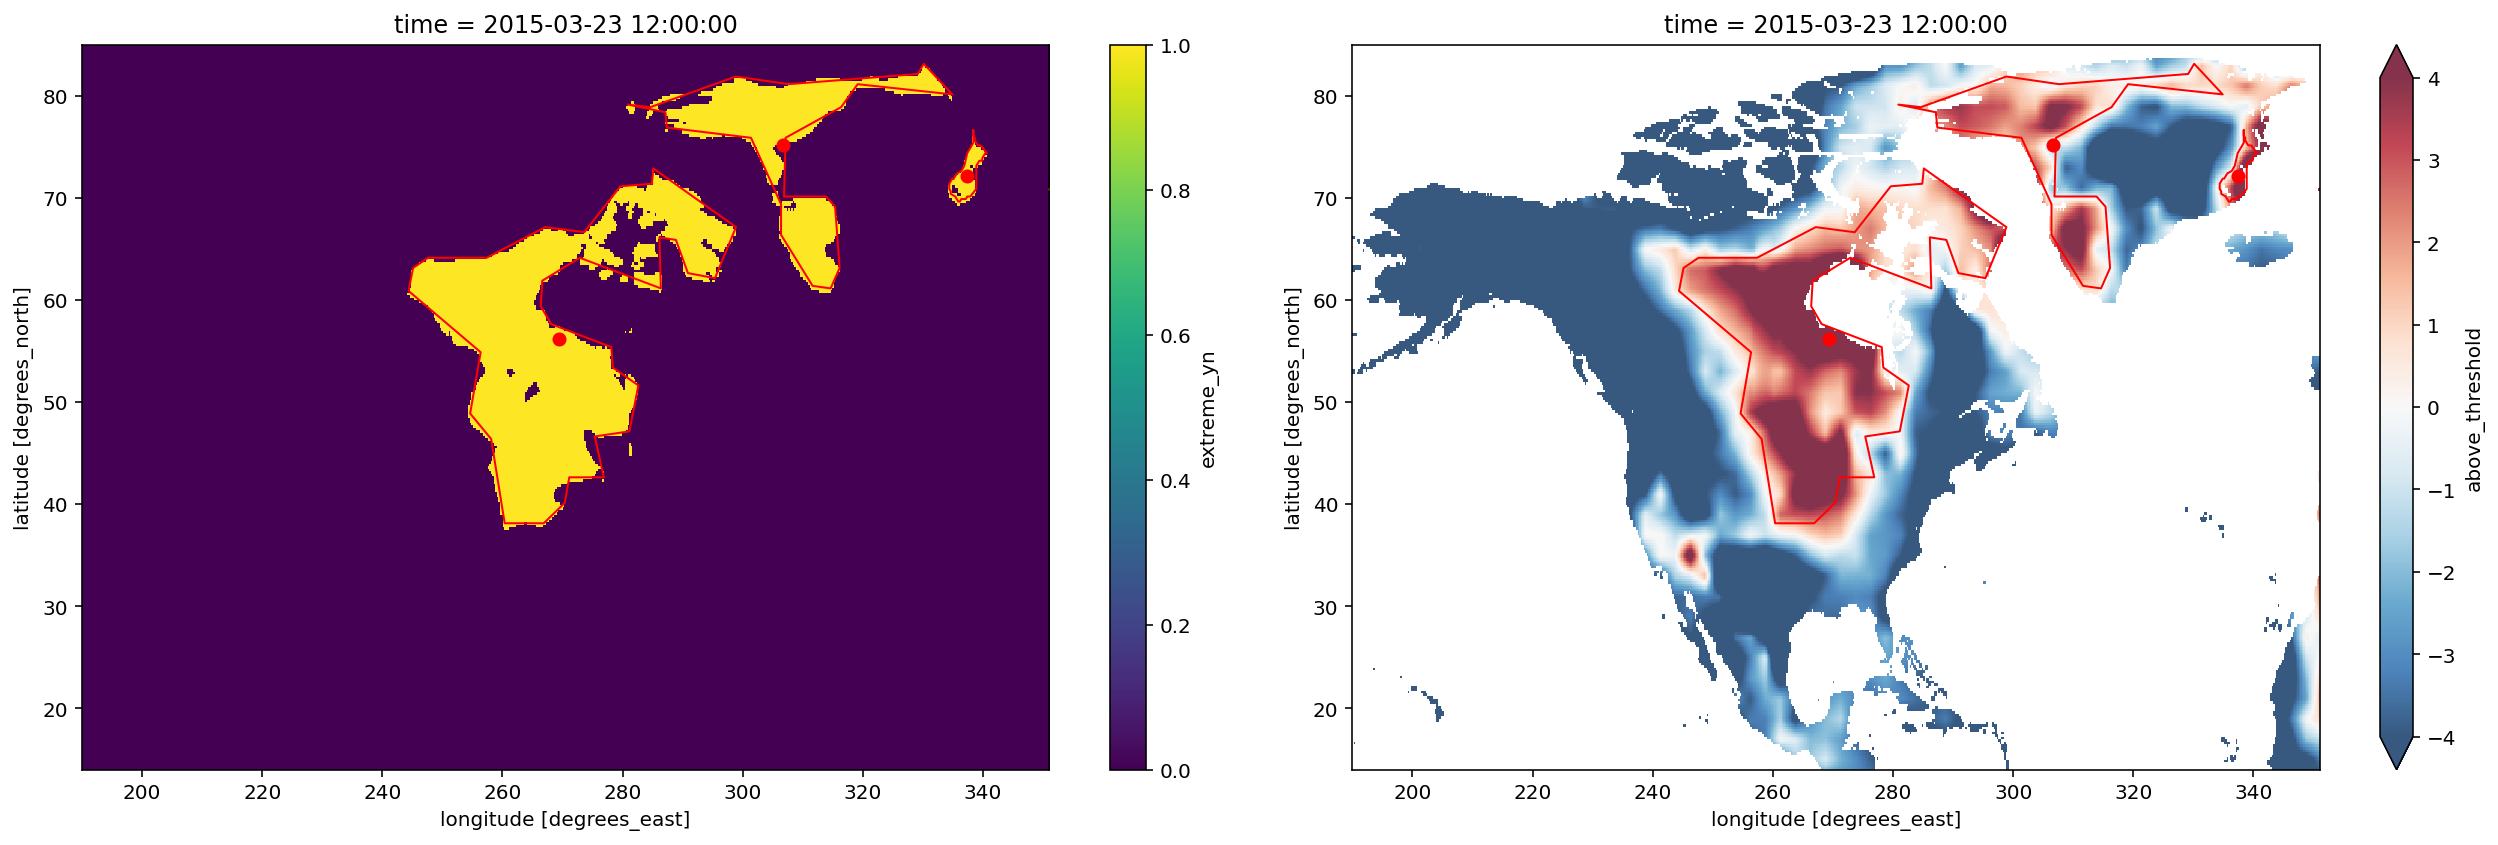

In [7]:
####################################
# Visualize a random day (slice)
####################################

# select the day to plot
##############
idx = 81    # <- play !
##############

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA) 

# add these patches on the plot(s)
patches = [Polygon(c.projected.squeeze(), True) for c in contours]

args = dict(edgecolors=("r",), linewidths=(1,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
[ax1.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]
p = PatchCollection(patches, **args)
ax2.add_collection(p)
[ax2.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]

fig.tight_layout()

On the left is a 2D array with each pixel showing if the geolocation was a part of the heat event or not, labeled as 1 or 0, colored by yellow and purple, respectively. On the right we see the temperature difference between the day and the 30-years average. 

Next, we apply the same function on each day of a dataset and obtain a collection of independent *Contour*s for each day. The result looks like in the column contours in Table 3. Each *Contour* object is represented by a unique hash id and holds all attributes wrapped under the instance implicitly.


## Find All Contours in a Dataset

In [6]:
%%time
####################################
# Rolling-window contours summation on time axis
####################################

def find_daily_contours(ds:xr.Dataset)->pd.DataFrame:
    """Give a dataset and it will loop through days and
    find all contours per day, if any. This function does ~
    df['contours'].rolling(window=4).sum() """
    
    dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

    all_contours = []
    days = []
    for d in dr:
        day = d.strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        arr2d = extreme.values[0]

        all_contours += [find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA)]
        days += [day]

    df = pd.DataFrame(dict(days=days, contours=all_contours))

    assert len(ds['extreme_yn'])==len(df)
    
    return df
    
df_daily = find_daily_contours(ds)
df_daily

CPU times: user 2.54 s, sys: 1.09 s, total: 3.63 s
Wall time: 5.69 s


days                                           contours
0    2015-01-01                   [72af14, 7389e0, 6cce90, 1dd525]
1    2015-01-02           [bf416a, 066244, 60efcc, fb8530, 150135]
2    2015-01-03   [f5bf11, 01e7b6, 39fe4c, 10bad1, c2249d, 05ba93]
3    2015-01-04  [ee2b0c, 7c31c5, 066e6f, bbfa94, a2d9a4, 4b544...
4    2015-01-05   [417642, 9d24ba, 0cc26e, e70001, b37197, e848ef]
..          ...                                                ...
360  2015-12-27                           [c1e4b8, 50c1fb, e9265f]
361  2015-12-28                                   [f84b43, 90532c]
362  2015-12-29                           [1bbfc4, cbf91b, d0fbed]
363  2015-12-30                   [1453d4, be8b26, fd1fab, 1c2630]
364  2015-12-31                           [8f4b51, b0bf03, 67bc6f]

[365 rows x 2 columns]

The dataframe above shows the detected *Contour* objects for each day of the dataset. Note that most of the days there are multiple, simultaneous *Contour*s, none overlapping. Also note that all are larger in area than the threshold we defined earlier, `MIN_AREA`. So far, no interaction between the *Contour*s occurred. 

Next, we define a rolling window of `N` days, and aggregate using the `sum` function. This is analogous to the popular `pandas` operation which could be described by pseudo-code: `df.rolling(window=4).sum()`. We append the results to the data frame, where the column `rolling_append` holds the collections of *Contour* objects and `rolling_sum` holds their aggregated sums.


## Contours Rolling-Sum Operations

In [8]:
%%time
####################################
# Read dataset
####################################

ROLLING = 4

def collapse(contours:List[Contour]) -> List[Contour]:
    """Recursive func to fuse multiple contour objects, if overlapping."""
    
    if type(contours)==float and pd.isna(contours):
        return []
    
    conts = contours[:] # prevent mutation
    for cnt1, cnt2 in itertools.combinations(conts, 2):
        if cnt1.position_to(cnt2) in ("inside", "intersect"):
            cnt_new = cnt1+cnt2
            conts.remove(cnt1)
            conts.remove(cnt2)
            conts.append(cnt_new)
            return collapse(conts) # recursion
        
    return conts

def rolling_sum(df:pd.DataFrame, window:int)->pd.DataFrame:
    """Provide df with daily contours calculated, and it will df.rolling(w).sum()
    The only reason we can't use pandas is that its .rolling method refuses sum(lists)."""
    
    if window==1:
        warnings.warn("window=1 just returns contours as-is.")
        
    df2 = pd.DataFrame()
    df2['days'] = df['days']
    df2['contours'] = df['contours']
    
    for i in range(1, window):
        df2[f"shift{i}"] = df['contours'].shift(i)

    df2['rolling_append'] = df2.filter(regex=r'contours|shift*', axis=1).dropna().sum(axis=1)
    df2['rolling_sum'] = df2['rolling_append'].apply(collapse)

    # drop tmp columns:
    df2 = df2[[c for c in df2.columns if "shift" not in c]]
    df2 = df2.drop("rolling_append", axis=1)
    
    assert len(ds['extreme_yn'])==len(df2)

    return df2['rolling_sum']

df_daily['rolling_sum'] = rolling_sum(df_daily, ROLLING)

df_daily

CPU times: user 1.12 s, sys: 7.14 ms, total: 1.12 s
Wall time: 1.12 s


days                                           contours  \
0    2015-01-01                   [72af14, 7389e0, 6cce90, 1dd525]   
1    2015-01-02           [bf416a, 066244, 60efcc, fb8530, 150135]   
2    2015-01-03   [f5bf11, 01e7b6, 39fe4c, 10bad1, c2249d, 05ba93]   
3    2015-01-04  [ee2b0c, 7c31c5, 066e6f, bbfa94, a2d9a4, 4b544...   
4    2015-01-05   [417642, 9d24ba, 0cc26e, e70001, b37197, e848ef]   
..          ...                                                ...   
360  2015-12-27                           [c1e4b8, 50c1fb, e9265f]   
361  2015-12-28                                   [f84b43, 90532c]   
362  2015-12-29                           [1bbfc4, cbf91b, d0fbed]   
363  2015-12-30                   [1453d4, be8b26, fd1fab, 1c2630]   
364  2015-12-31                           [8f4b51, b0bf03, 67bc6f]   

                                           rolling_sum  
0                                                   []  
1                                                   []  
2                                                   []  
3    [7c31c5, bbfa94, b32ebd, 543f21, ba14f4, 75ffc...  
4    [c8416a, 7e9103, bd112d, 715189, adde01, 9585d...  
..                                                 ...  
360                   [99b151, 235d11, 227898, e73724]  
361                   [e207e4, ef8a57, d56a3d, b1162e]  
362                           [c424b8, a1245d, b30ca5]  
363                           [c1e4b8, d6f0b9, 103d76]  
364                                   [e85718, 0e27a1]  

[365 rows x 3 columns]

Conceptually, this is analogous to the popular map-reduce operation. In our case, we sum a collection of Contours on time axis (3rd dimension of our `xarray.Dataset`). One nuance is that in a simpler example, the sum of multiple floats returns a single `float`. However, in our case the sum of multiple *Contour*s returns a new set of *Contour*s. To achieve this, we defined a recursive function, `collapse`, to reduce a collection of *Contour*s by iteratively fusing the overlapping pairs until each *Contour* in the window is distinct. 

The output is a *ContoursCollection*, which has the minimum output count 1 if a larger *Contour* swallowed all others (within the same window). And the maximum output count is `N` if a window contained `N` non-overlapping (distinct) *Contour*s. Often, the outcome is between 1 and `N`.

## Generate Contours For a Range of Dates

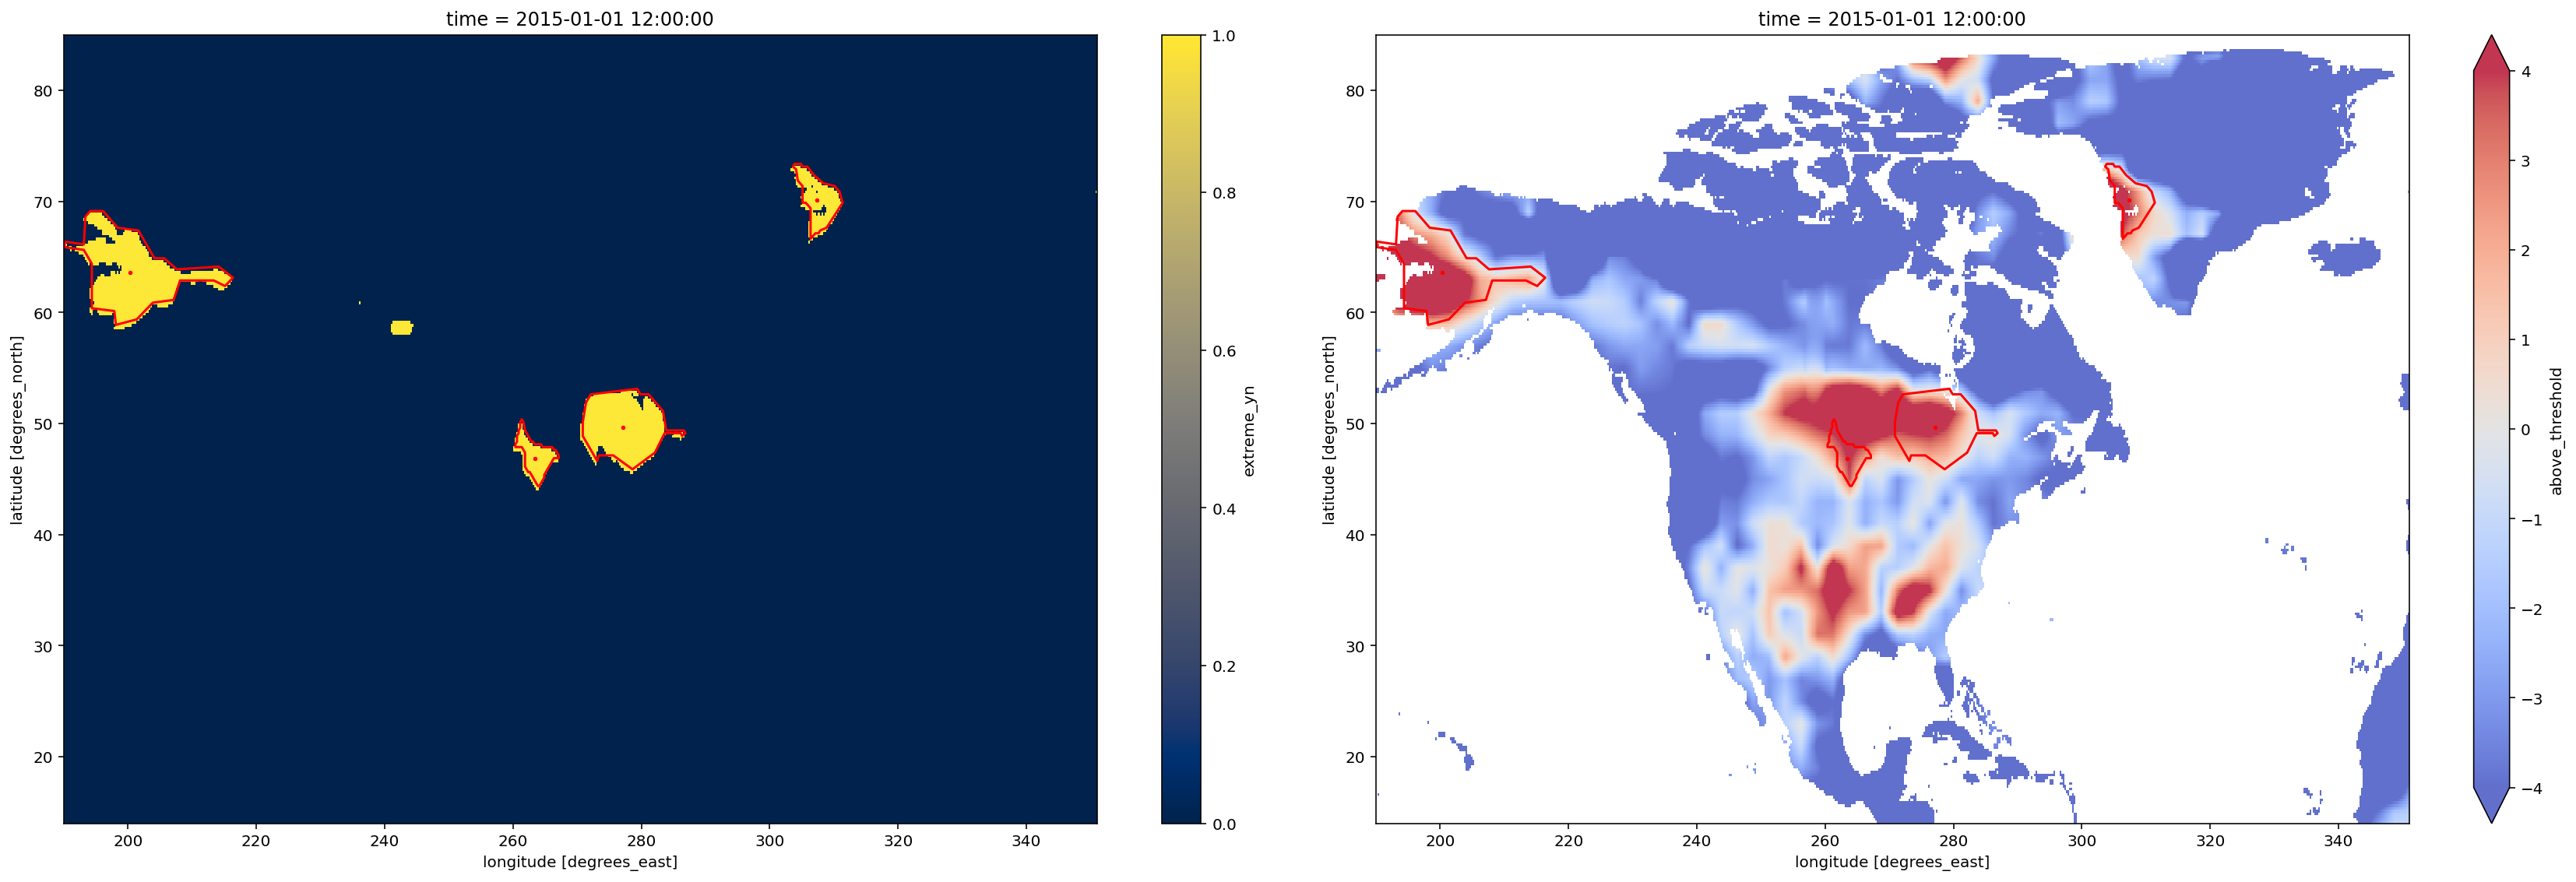

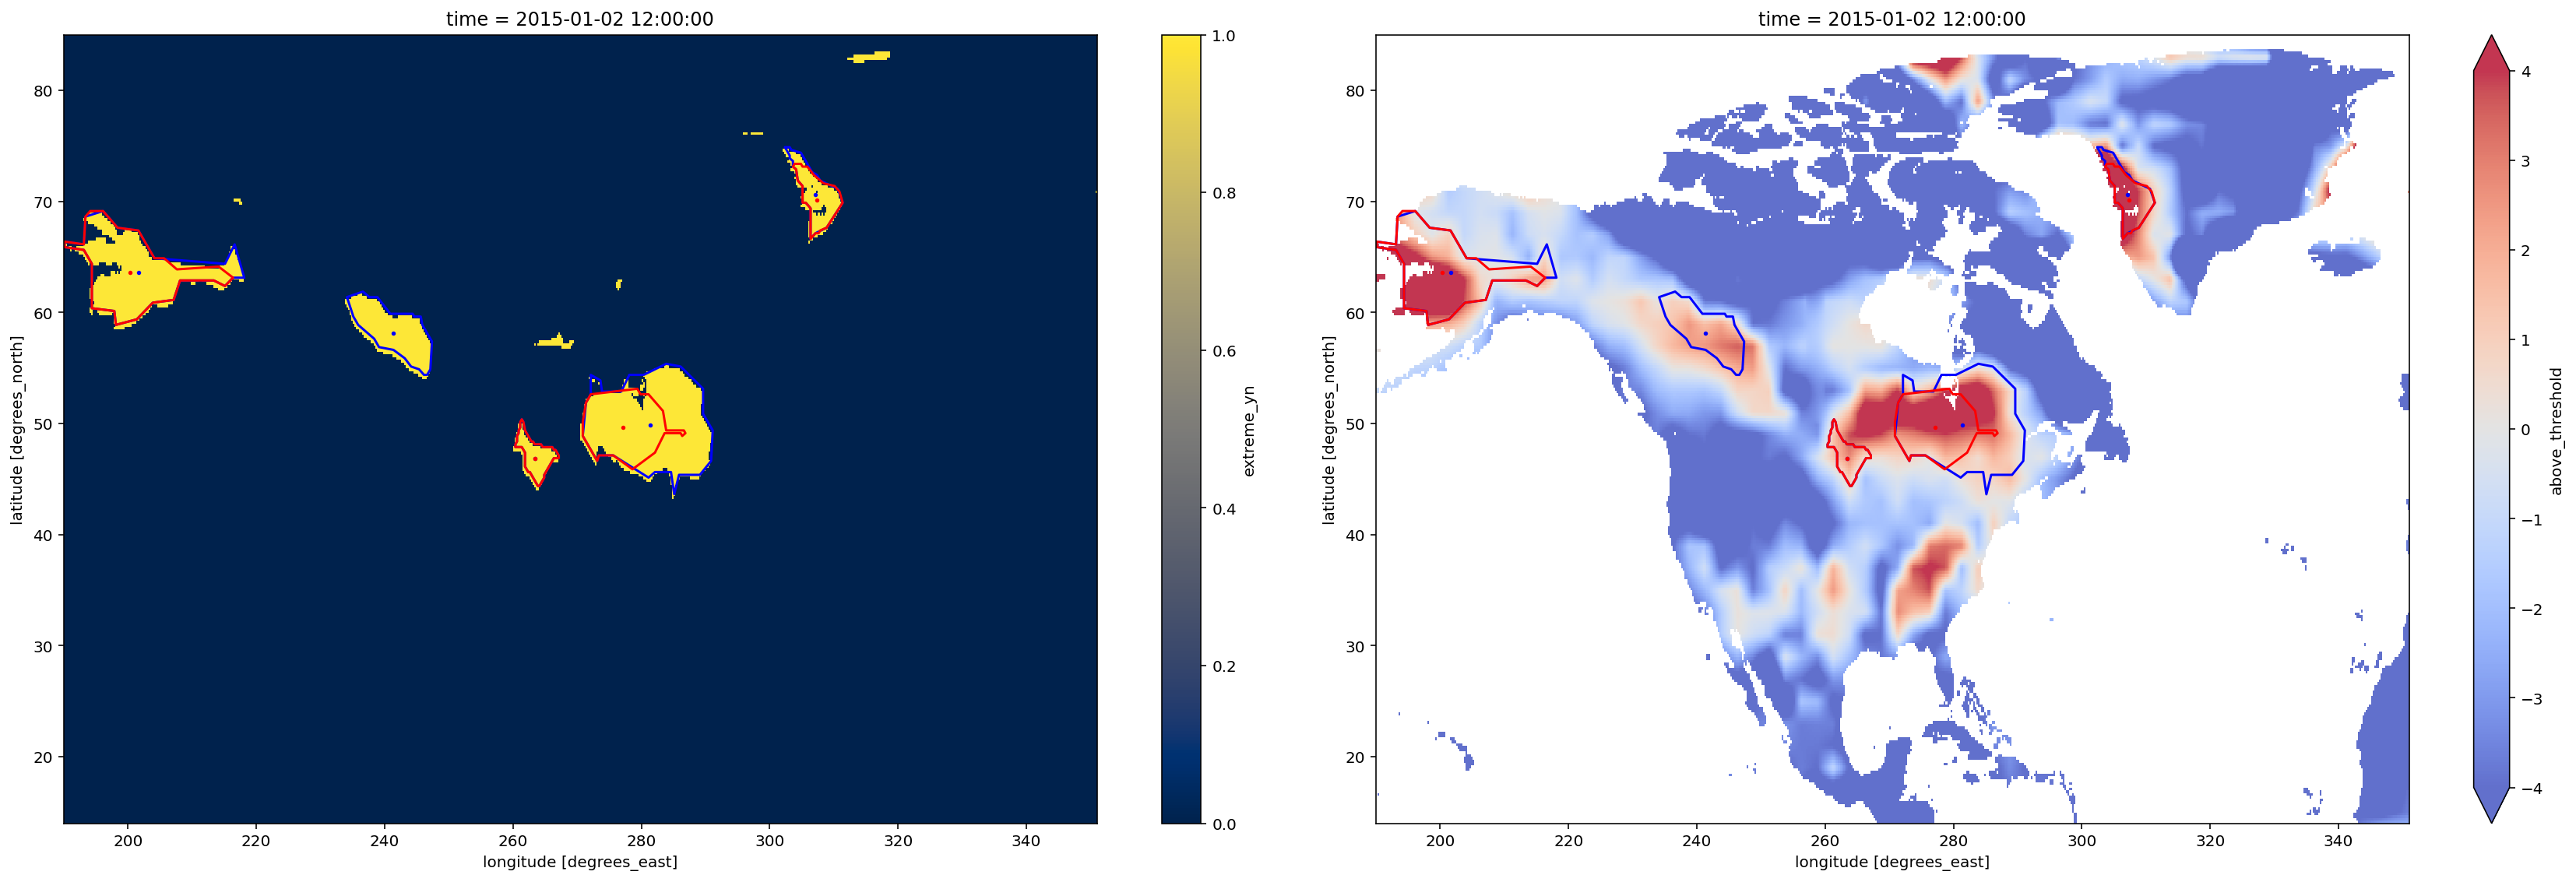

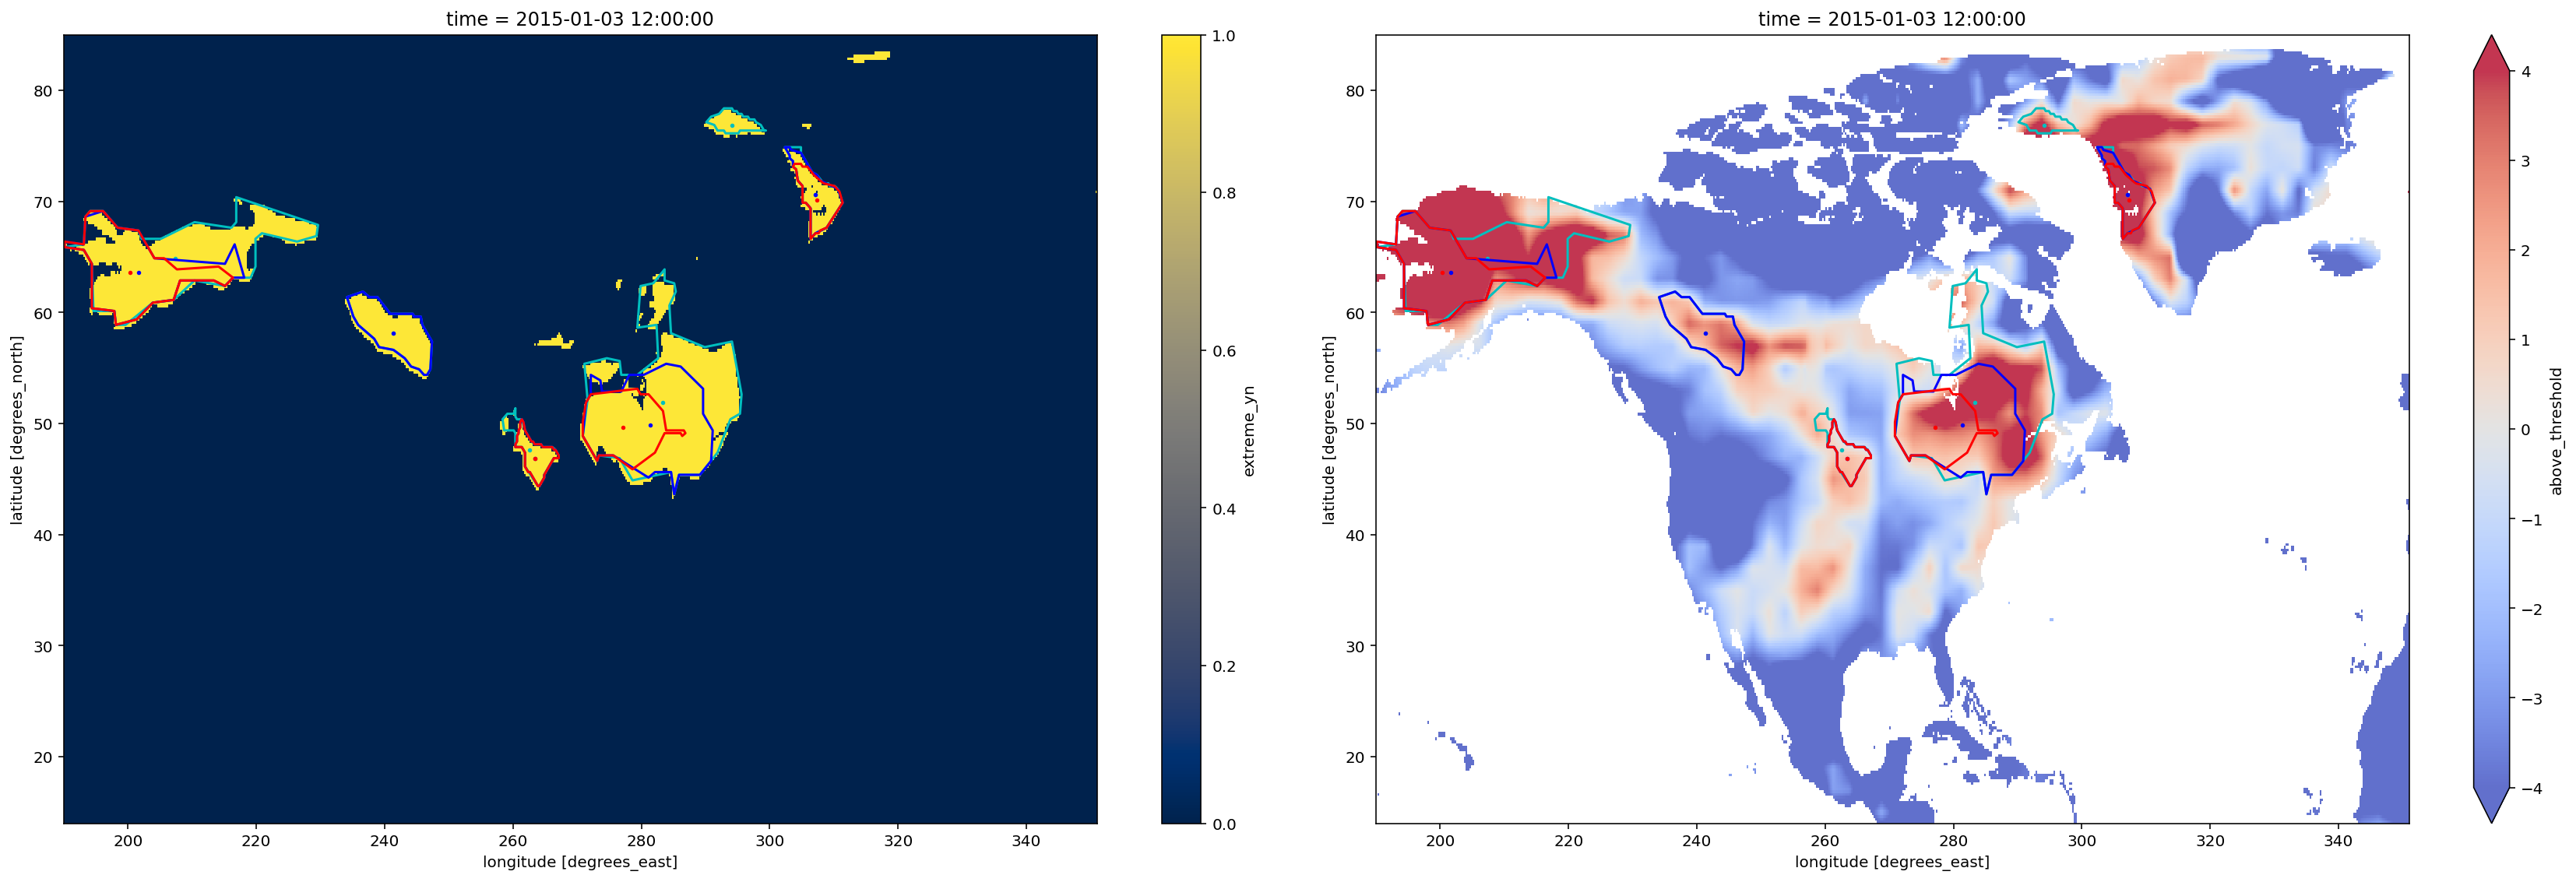

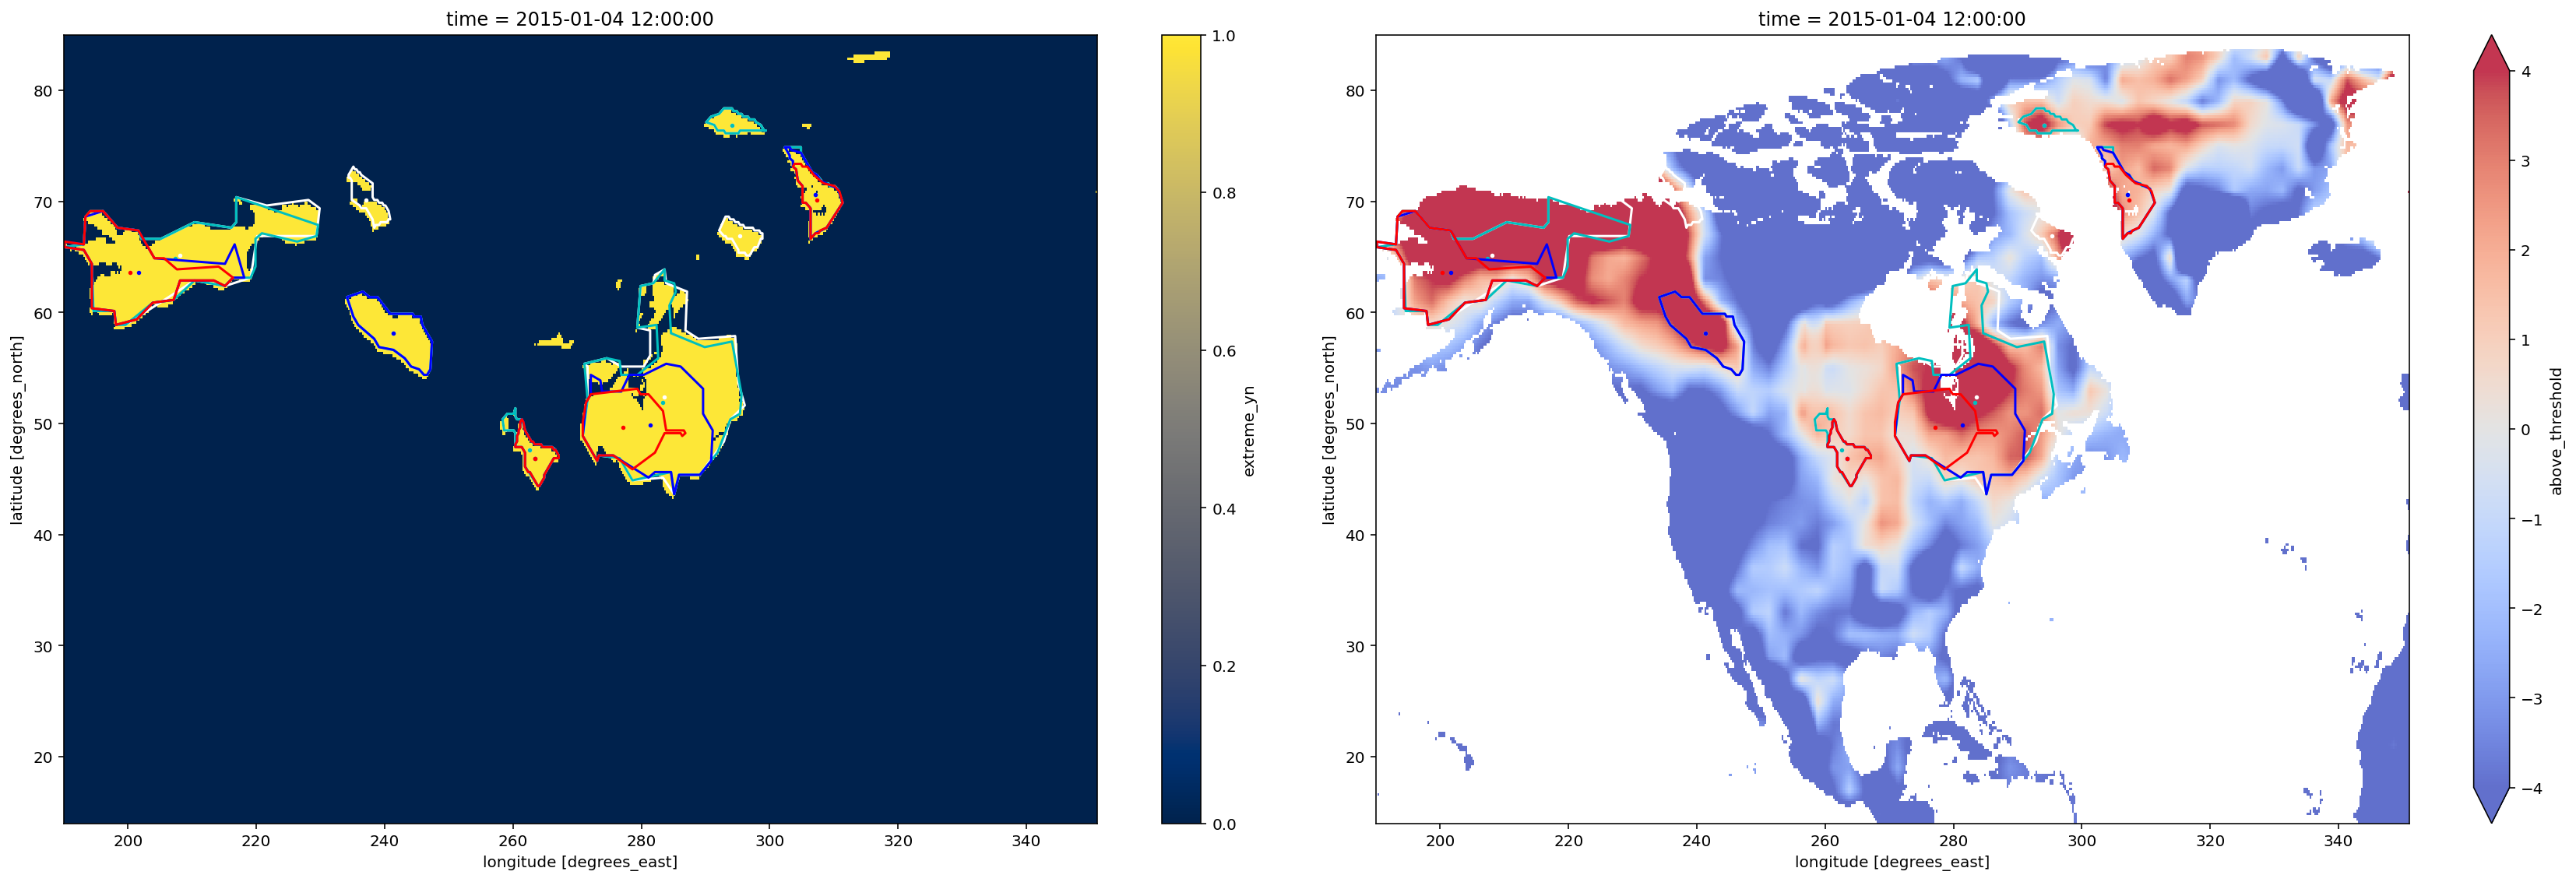

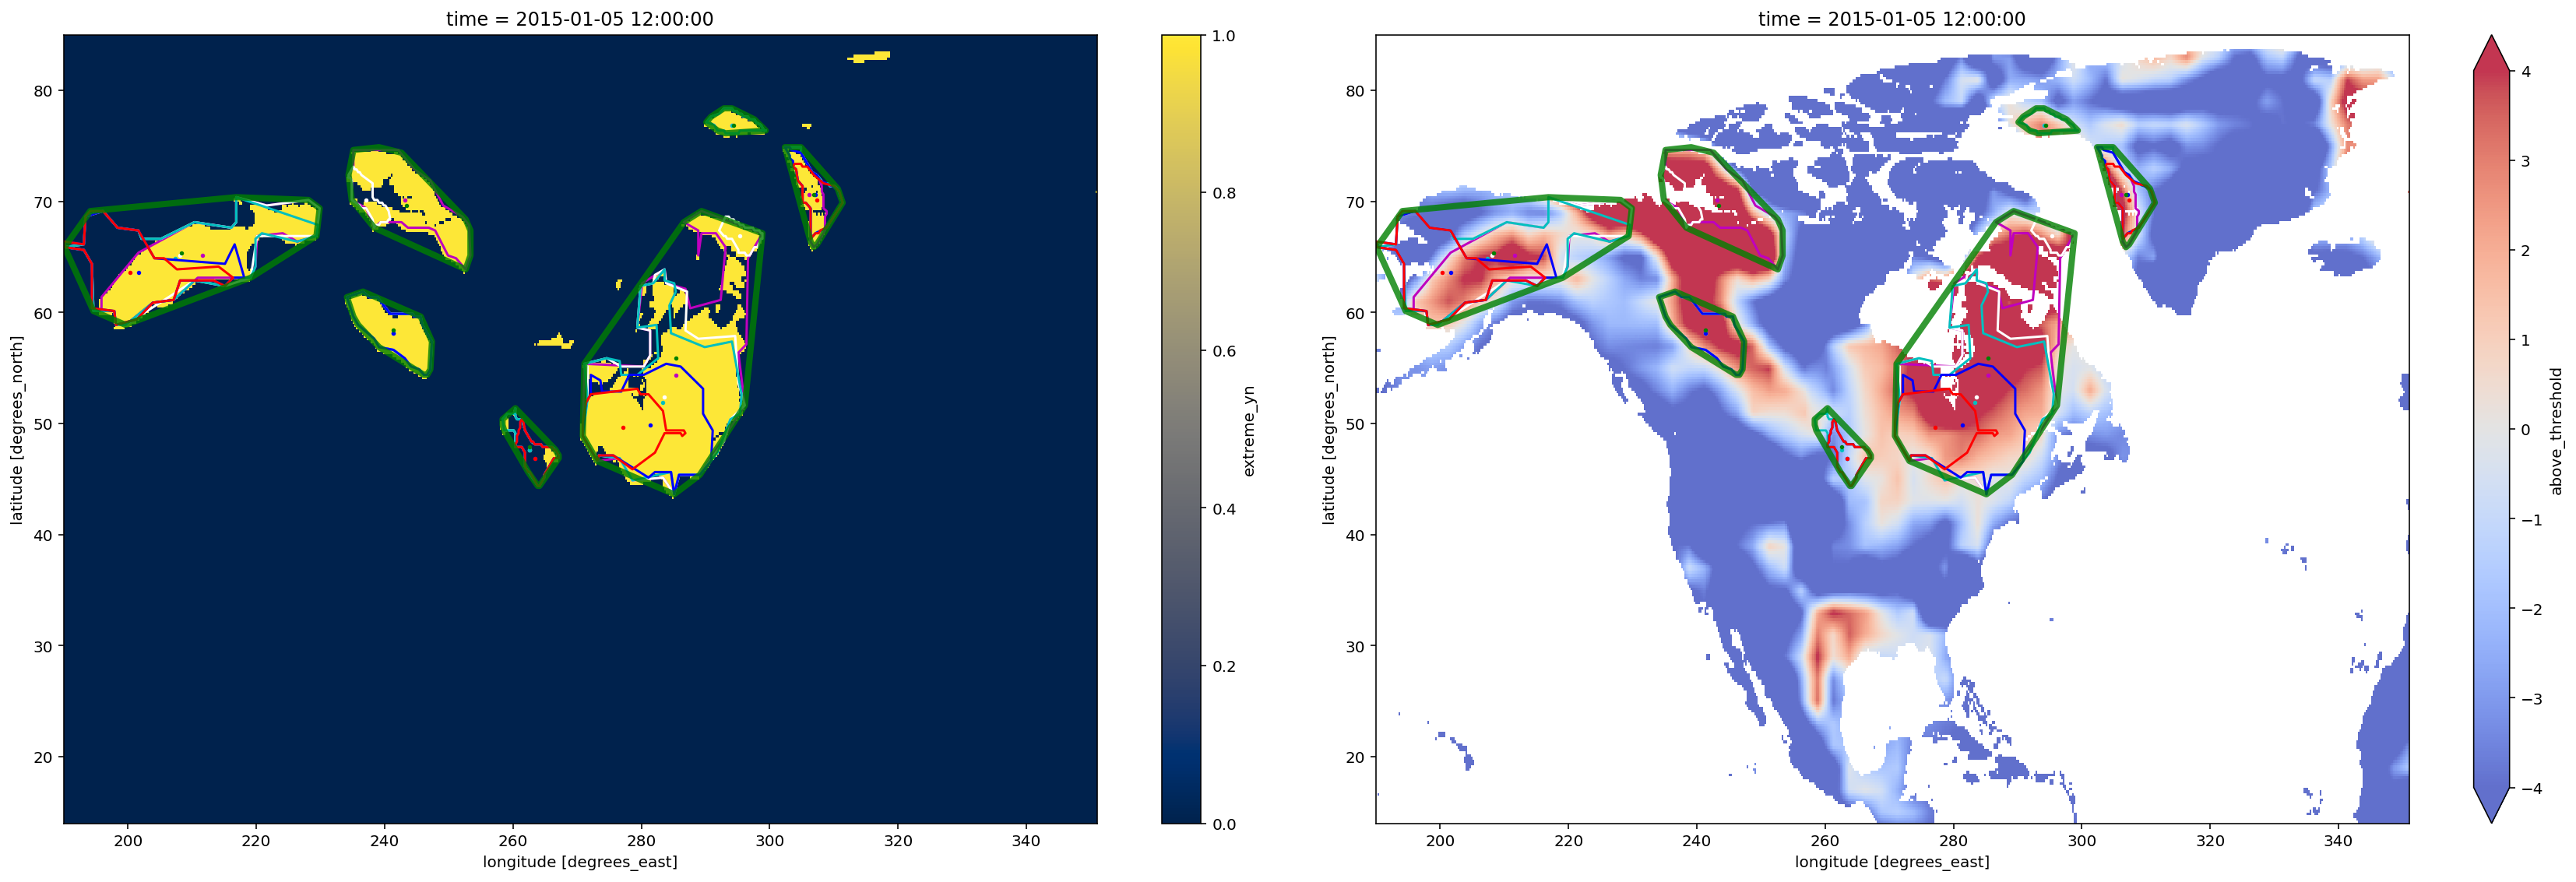

In [25]:
####################################
# Pipeline to generate fig for each day with contours
####################################

IMG_FOLDER = f"{YEAR}_images"

def validate(df:pd.DataFrame):
    """Ensure dimensions are correct."""
    
    assert "contours" in df.columns
    assert "rolling_sum" in df.columns
    assert df.index.is_monotonic
    
def plot_contours(df:pd.DataFrame, window:int, save=False):  
    """For a given dataframe of days and Contours, generate figures with Contours
    drawn as polyngons on them. For each day, also draw the contours from the previous N days.
    Also, draw the rolling-summed contour (green, thick convexHull)."""
    
    validate(df)
    
    def add_patches(column:str, _idx:int, color:str, linewidths:int, alpha=1):
        """Add polyn omial pathches projected on the figures."""
        
        contours = df[column][df.index==_idx].values[0]
        patches = [Polygon(c.projected.squeeze(), True) for c in contours]

        args = dict(edgecolors=(color,), linewidths=(linewidths,), facecolor="none", alpha=alpha)
        
        p = PatchCollection(patches, **args)
        ax1.add_collection(p)
        [ax1.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]
        
        p = PatchCollection(patches, **args)
        ax2.add_collection(p)
        [ax2.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]
    
    for i, idx in enumerate(df.index):

        """Loop through the days and for each day, plot the 2D slice from the 
        dataset as the background data (heat-events data & tasmax_diff data), and
        add Contours of the moving last-N days on each plot."""
        
        dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
        day = dr[idx].strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))

        im1 = extreme.squeeze().plot.imshow(ax=ax1, cmap='cividis')
        im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='coolwarm', vmin=4, vmax=-4, alpha=0.8)

        colors = 'r b c w m g y'.split()*100
        for x in range(i+1):
            add_patches('contours', idx-x, colors[i-x], 1.5)
            if x==window:
                add_patches('rolling_sum', idx, 'g', 4, alpha=0.8) 
                break

        fig.tight_layout()
        
        if save:
            # save image locally
            if not os.path.exists(IMG_FOLDER):
                os.mkdir(IMG_FOLDER)
            fig.savefig(f"{IMG_FOLDER}/{day}.jpg")

            plt.close(fig)
        
plot_contours(df_daily.head(), window=ROLLING, save=False)

In this example, we used heat-events data from inputs: 4days, 5°K above, Avg_years_1950-1979, climate model Ssp245, Region-1, days from Jan 6th to 9th, 2015. For each day the rolling window drops the Contours from the tail and adds the next day’s Contours. 

## Functions to Upload Outputs to Azure

Please make sure to give "write" permissions when creating the SAS token.

In [351]:
# get your sas token from Azure
sas_token = getpass.getpass() 

 ·············································································································································


In [353]:
####################################
# Util func to upload a file to Azure
####################################

URL_PREFIX = 'https://nasanex30analysis.blob.core.windows.net'
BLOB_FOLDER = "cmip6/contours"
    
def toAzure(fn:str, sas_token:str):
    """Upload a single file to Azure blob."""
    
    sas_url = f"{URL_PREFIX}/{BLOB_FOLDER}/{fn}?{sas_token}"
    blob_client = BlobClient.from_blob_url(sas_url)
    
    with open(fn, "rb") as f:
        try:
            blob_client.upload_blob(f)
        except ResourceExistsError:
            raise ResourceExistsError(fn)
            

## Compile Video of Contour Visualizations

In [345]:
%%time
####################################
# Compile a video from images
####################################

PATH_VIDEO = f"{YEAR}.mp4"

def create_video(files:List[str], fn_out:str)->None:
    """Compile multiple images into single mp4 video."""
    
    h,w,_ = cv2.imread(files[0]).shape

    with tempfile.TemporaryFile() as f:

        fp = f"{f.name}.avi"
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video = cv2.VideoWriter(fp, fourcc, 10, (w,h))

        for fn in files:
            img = cv2.imread(fn)
            video.write(img)

        video.release()
        os.rename(fp, 'out.avi')
        time.sleep(2)

    fn_in = 'out.avi'
    cmd = f"ffmpeg -i '{fn_in}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{fn_out}'"
    print("converting avi to mp4..")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)  
    
    os.remove('out.avi')


files = sorted([str(p) for p in Path(IMG_FOLDER).rglob("*.jpg")])

create_video(files, PATH_VIDEO)

converting avi to mp4..
CPU times: user 5.69 s, sys: 98.7 ms, total: 5.79 s
Wall time: 12.5 s


For instance, the links below show the 10-year outputs from 2020-2030, for 4 different climate models. Inputs are: temperature 4days and 5°K above, Avg_years_1950-1979, Region-1.

[GFDL ESM4 ssp245](https://youtu.be/hDs73QtHfv0)
[GFDL ESM4 ssp585](https://youtu.be/uSojwxGyWUQ)
[GISS E2 1 G ssp245](https://youtu.be/PCutsAQ3biQ)
[GISS E2 1 G ssp585](https://youtu.be/VCE3C2o_oB8)

## Serialization of the Contours Metadata

First artifact is the meta data extract. We added a serializer to convert the *Contour* objects to json format before uploading the results of the processed dataset to Azure. This was a straightforward implementation of exploding a data frame for each unique day and *Contour* and extracting the class attributes to new columns. This way anyone can import the meta data into pandas without the need to access our source code.

In [10]:
%%time
####################################
# Serialize metadata before pickle
####################################

df1 = df_daily.explode('contours')[['days','contours']].reset_index(drop=True)
df1['type'] = 'daily'
df1 = df1.rename({'contours':'contour'}, axis=1)

df2 = df_daily.explode('rolling_sum')[['days','rolling_sum']].reset_index(drop=True)
df2['type'] = 'rolling_sum'
df2 = df2.rename({'rolling_sum':'contour'}, axis=1)

df3 = pd.concat([df1,df2], axis=0)\
            .sort_values(by=['days','type'], ascending=True)\
            .dropna()\
            .reset_index(drop=True)

df3['name'] = [x.name for x in df3['contour']]
df3['center'] = [x.center for x in df3['contour']]
df3['area'] = [x.area for x in df3['contour']]
df3['projected'] = [x.projected for x in df3['contour']]
df3 = df3.drop('contour', axis=1)
df_meta = df3

# save metadata on disk
PATH_META = f"{YEAR}.json" 
df_meta.to_json(PATH_META)

CPU times: user 9.35 s, sys: 0 ns, total: 9.35 s
Wall time: 9.34 s


In [26]:
df_meta.iloc[20:30]

days         type    name             center    area  \
20  2015-01-04        daily  4b544a  (241.375, 58.125)   745.0   
21  2015-01-04        daily  d4ad27  (262.625, 47.625)   310.5   
22  2015-01-04        daily  2b25a8  (283.625, 52.375)  4558.0   
23  2015-01-04  rolling_sum  7c31c5  (237.125, 70.125)   231.5   
24  2015-01-04  rolling_sum  bbfa94  (295.375, 66.875)   195.5   
25  2015-01-04  rolling_sum  b32ebd  (294.375, 76.875)   212.0   
26  2015-01-04  rolling_sum  543f21  (241.375, 58.375)   847.0   
27  2015-01-04  rolling_sum  ba14f4  (306.875, 70.875)   600.0   
28  2015-01-04  rolling_sum  75ffc1  (208.375, 65.375)  4815.0   
29  2015-01-04  rolling_sum  b4dcb7  (262.625, 47.875)   463.5   

                                            projected  
20  [[[247.125, 54.875]], [[246.625, 54.375]], [[2...  
21  [[[267.125, 46.875]], [[266.375, 46.875]], [[2...  
22  [[[285.125, 43.625]], [[283.375, 45.125]], [[2...  
23  [[[240.875, 68.375]], [[240.625, 68.375]], [[2...  
24  [[[298.875, 66.625]], [[298.625, 66.625]], [[2...  
25  [[[299.375, 76.375]], [[297.625, 77.375]], [[2...  
26  [[[247.125, 54.875]], [[247.375, 57.375]], [[2...  
27  [[[311.375, 69.875]], [[310.625, 71.125]], [[3...  
28  [[[229.875, 69.375]], [[228.125, 70.125]], [[2...  
29  [[[267.125, 46.875]], [[267.125, 47.125]], [[2...

In [354]:
####################################
# Upload all outputs to Azure
####################################

# upload 1 contours metadata
toAzure(PATH_META, sas_token)

# upload 365 images
files = sorted([str(p) for p in Path(IMG_FOLDER).rglob("*.jpg")])
for fn in files:
    toAzure(fn, sas_token)

# upload 1 video
toAzure(PATH_VIDEO, sas_token)

In [ ]:
####################################
# Clean up Planatery Computer VM drive
####################################

# shutil.rmtree(IMG_FOLDER) # use with caution.